> Given clinical parameters about a patient, can we predict whether or not they have heart disease?

## Data

The original data came from the Cleavland data from the UCI Machine Learning Repository. https: // archive.ics.uci.edu/ml/datasets/heart+Disease

There is also a version of it available on Kaggle. https: // www.kaggle.com/ronitf/heart-disease-uci

## existing columns in data

1. age - age in years
2. sex - (1 = male; 0 = female)
3. cp - chest pain type
    * 0: Typical angina: chest pain related decrease blood supply to the heart
    * 1: Atypical angina: chest pain not related to heart
    * 2: Non-anginal pain: typically esophageal spasms (non heart related)
    * 3: Asymptomatic: chest pain not showing signs of disease
4. trestbps - resting blood pressure (in mm Hg on admission to the hospital) anything above 130-140 is typically cause for concern
5. chol - serum cholestoral in mg/dl
    * serum = LDL + HDL + .2 * triglycerides
    * above 200 is cause for concern
6. fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
    * '>126' mg/dL signals diabetes
7. restecg - resting electrocardiographic results
    * 0: Nothing to note
    * 1: ST-T Wave abnormality
        * can range from mild symptoms to severe problems
        * signals non-normal heart beat
    * 2: Possible or definite left ventricular hypertrophy
        * Enlarged heart's main pumping chamber
8. thalach - maximum heart rate achieved
9. exang - exercise induced angina (1 = yes; 0 = no)
10. oldpeak - ST depression induced by exercise relative to rest looks at stress of heart during excercise unhealthy heart will stress more
11. slope - the slope of the peak exercise ST segment
    * 0: Upsloping: better heart rate with excercise (uncommon)
    * 1: Flatsloping: minimal change (typical healthy heart)
    * 2: Downslopins: signs of unhealthy heart
12. ca - number of major vessels (0-3) colored by flourosopy
    * colored vessel means the doctor can see the blood passing through
    * the more blood movement the better (no clots)
13. thal - thalium stress result
    * 1,3: normal
    * 6: fixed defect: used to be defect but ok now
    * 7: reversable defect: no proper blood movement when excercising
14. target - have disease or not (1=yes, 0=no) (= the predicted attribute)

In [1]:
# Import all the tools we need

from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# we want our plots to appear inside the notebook
%matplotlib inline


In [2]:
heart_diseace = pd.read_csv('data/heart-disease.csv')

In [4]:
heart_diseace.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1


In [7]:
# Checking if there are NaN values in df
heart_diseace.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

### Trying to find patterns between columns

In [8]:
# comparing sex and target column to check ratio between male and female

pd.crosstab(heart_diseace.sex, heart_diseace.target)

target,0,1
sex,,
0,24,72
1,114,93


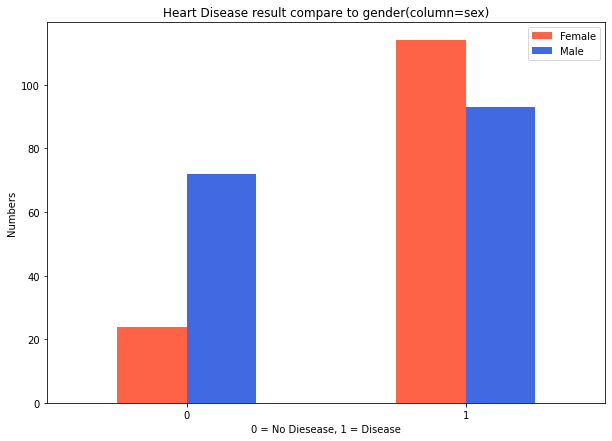

In [56]:
# visulising the crosstab result in a graph

pd.crosstab(heart_diseace.sex, heart_diseace.target).plot(kind='bar',
                                                          figsize=(10, 7),
                                                          color=[
                                                              'tomato', 'royalblue']
                                                          )

plt.title('Heart Disease result compare to gender(column=sex)')
plt.xlabel('0 = No Diesease, 1 = Disease')
plt.ylabel('Numbers')
plt.legend(["Female", "Male"])
plt.xticks(rotation=0)
plt.show()


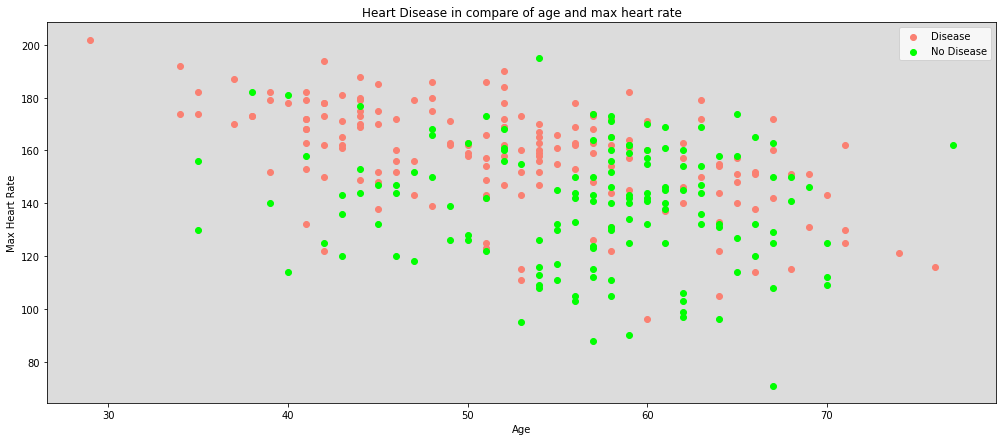

In [65]:
# Finding Relation between thalach(heart rate) and age column
plt.figure(figsize=(17,7))
plt.axes().set_facecolor('gainsboro')

plt.scatter(heart_diseace.age[heart_diseace['target']==1],
            heart_diseace.thalach[heart_diseace['target']==1],
            color='salmon'
)
plt.scatter(heart_diseace.age[heart_diseace['target'] == 0],
            heart_diseace.thalach[heart_diseace['target'] == 0],
            color='lime'
            )
plt.title('Heart Disease in compare of age and max heart rate')
plt.xlabel('Age')
plt.ylabel('Max Heart Rate')
plt.legend(['Disease', 'No Disease'])
plt.show()